In [716]:

import control as ct
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [717]:
def set_subplot(ax, x_data, y_data, xlabel, ylabel, title, line_color='#120a8f', linewidth=1.5):
  line, = ax.plot(x_data, y_data, linestyle='-',
                  color=line_color, linewidth=linewidth)
  ax.set_xlabel(xlabel, fontsize=18)
  ax.set_ylabel(ylabel, fontsize=18)
  ax.grid(linestyle='--')
  ax.set_title(title, fontsize=20)
  ax.tick_params(axis='both', direction='in', length=4, width=1,
                 colors='black', top=True, right=True, labelsize=16)

  return line

In [718]:
def sat(δud, UD_O):
  υ = min(1 - UD_O, UD_O)
  return max(min(δud, υ), -υ)

In [719]:

def upd_shifted(t, x, u, params):
  RL = params["RL"]
  L = params["L"]
  C = params["C"]
  R = params["R"]
  VC_O = params["VC_O"]
  VIN_O = params["VIN_O"]
  PL_O = params["PL_O"]
  IL_O = params["IL_O"]
  UD_O = params["UD_O"]

  δud, δv_in, δPl = u
  δiL, δvC = x

  A11 = - (RL / L)
  A12 = - (1. / L)
  A21 = 1. / C
  A22 = - (1. / (C * R)) + PL_O / (C * VC_O * (VC_O + δvC))
  A = np.array([[A11, A12], [A21, A22]])

  B11 = (VIN_O + δv_in) / L
  B = np.array([[B11], [0.]])

  E11 = UD_O / L
  E22 = - (1 / (C * (VC_O + δvC)))
  E = np.array([[E11, 0], [0, E22]])

  x = np.array([[δiL], [δvC]])
  u = np.array([[δud]])
  w = np.array([[δv_in], [δPl]])

  δx_dot = A @ x + B @ u + E @ w

  return δx_dot


shifted_system = ct.ss(upd_shifted, None, inputs=3, outputs=2, states=2)

In [720]:
# Parameter Definition

RL = 0.1
L = 1e-3
C = 2.2e-3
R = 20

VC_O = 24.
VIN_O = 48.
PL_O = 50.
IL_O = (1. / R) * VC_O + (1. / VC_O) * PL_O
UD_O = (RL / VIN_O) * IL_O + VC_O / VIN_O

VC_MIN = -0.1
VC_MAX = 0.1
VIN_MIN = -0.1
VIN_MAX = 0.1

z11 = 1 / (VC_O + VC_MIN)
z12 = 1 / (VC_O + VC_MAX)

z21 = VIN_O + VIN_MIN
z22 = VIN_O + VIN_MAX

Z = np.array([[min(z11, z12), max(z11, z12)],
             [min(z21, z22), max(z21, z22)]])

print(Z)

step = 1e-5
timepts = np.arange(0, 1e-1 + step, step)

U = np.array([UD_O, VIN_O, PL_O])
U_O = np.array([UD_O, VIN_O, PL_O])

X0 = 0.95 * np.array([IL_O, VC_O])
X0_O = np.array([IL_O, VC_O])

δU = U - U_O
δX0 = X0 - X0_O

params = {
    "RL": RL,
    "L": L,
    "C": C,
    "R": R,
    "VC_O": VC_O,
    "VIN_O": VIN_O,
    "PL_O": PL_O,
    "IL_O": IL_O,
    "UD_O": UD_O,
    "VC_MIN": VC_MIN,
    "VC_MAX": VC_MAX,
    "VIN_MIN": VIN_MIN,
    "VIN_MAX": VIN_MAX,
}

print(f"IL_O = {IL_O}, UD_O = {UD_O}")

[[4.14937759e-02 4.18410042e-02]
 [4.79000000e+01 4.81000000e+01]]
IL_O = 3.283333333333333, UD_O = 0.5068402777777777


In [721]:
t, y = ct.input_output_response(
    sys=shifted_system, T=timepts,
    U=list(δU), X0=δX0, params=params,
)

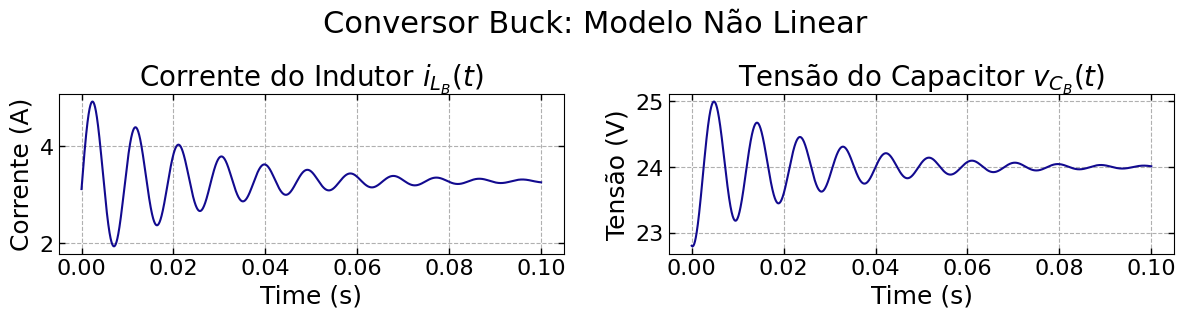

In [722]:
# Definindo o tamanho da figura e os subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 3.2))

# Adicionando o título à figura
fig.suptitle("Conversor Buck: Modelo Não Linear", fontsize=22)

set_subplot(
    axs[0], t, y[0] + IL_O,
    'Time (s)', 'Corrente (A)', 'Corrente do Indutor $i_{L_B}(t)$',
)

# Configurando o subplot da Tensão do Capacitor
set_subplot(
    axs[1],  t, y[1] + VC_O,
    'Time (s)', 'Tensão (V)', 'Tensão do Capacitor $v_{C_B}(t)$',
)

plt.tight_layout()

In [723]:
def z1(δvC):
  return (1. / (VC_O + δvC))


def z2(δv_in):
  return (VIN_O + δv_in)


def A(z):
  A11 = - (RL / L)
  A12 = - (1. / L)
  A21 = 1. / C
  A22 = - (1. / (C * R)) + (PL_O / (C * VC_O)) * z[0]

  return np.array([[A11, A12], [A21, A22]])


def B(z):
  B11 = (1. / L) * z[1]
  return np.array([[B11], [0]])


def E(z):
  E11 = UD_O / L
  E22 = - (1. / C) * z[0]
  return np.array([[E11, 0], [0, E22]])


def upd_fuzzy(t, x, u, params):

  δud, δv_in, δPl = u
  δiL, δvC = x

  B2 = list(itertools.product([0, 1], repeat=2))

  δx_dot = 0
  x = np.array([[δiL], [δvC]])
  u = np.array([[sat(δud, UD_O)]])
  w = np.array([[δv_in], [δPl]])

  zt = [z1(δvC), z2(δv_in)]

  M = []
  for i in range(0, 2):
    m = (zt[i] - Z[i][0]) / (Z[i][1] - Z[i][0])
    M.append([1. - m, m])

  for p in B2:
    hp = 1.
    z = []
    for i, b in enumerate(p):
      hp *= M[i][b]
      z.append(Z[i][b])

    Ap = A(z)
    Bp = B(z)
    Ep = E(z)

    δx_dot = hp * (Ap @ x + Bp @ u + Ep @ w)

  return δx_dot


fuzzy_model = ct.ss(upd_fuzzy, None, inputs=3, outputs=2, states=2)

In [724]:
t, y = ct.input_output_response(
    sys=fuzzy_model, T=timepts,
    U=list(δU), X0=δX0, params=params,
)

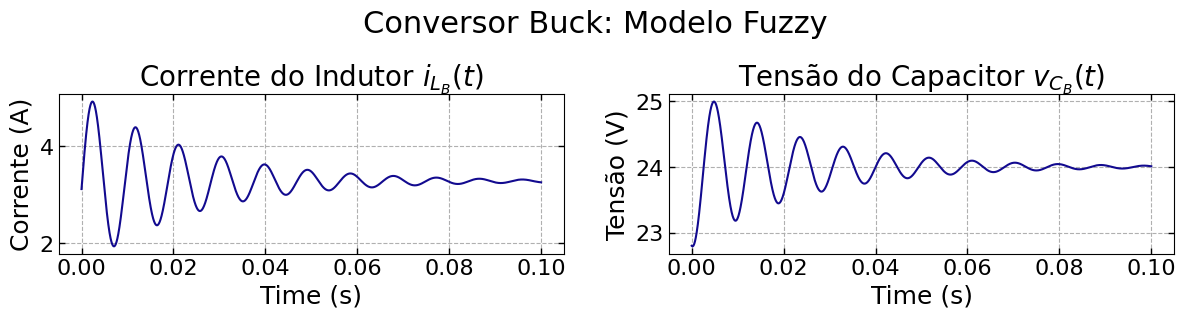

In [725]:
# Definindo o tamanho da figura e os subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 3.2))

# Adicionando o título à figura
fig.suptitle("Conversor Buck: Modelo Fuzzy", fontsize=22)

set_subplot(
    axs[0], t, y[0] + IL_O,
    'Time (s)', 'Corrente (A)', 'Corrente do Indutor $i_{L_B}(t)$',
)

# Configurando o subplot da Tensão do Capacitor
set_subplot(
    axs[1],  t, y[1] + VC_O,
    'Time (s)', 'Tensão (V)', 'Tensão do Capacitor $v_{C_B}(t)$',
)

plt.tight_layout()